# Spatial resampling of gridded ECMWF data onto a satellite's swath

## Comparison between MetView and pyResample

For the retrieval of physical parameters in the atmosphere via Optimal Estimation, we need apriori knowlegdge of the quantity we want to retrieve; this apriori knowledge can be obtained from a forecast model. 

A walk-through on how this apriori knowledge can be obtained has been presented [here](https://github.com/deweatherman/ExtractApriori/blob/main/ExtractApriori_v1.ipynb). 

The goal in this notebook is to compare plainly the *Nearest Neighbours with Gaussian weights* from *pyResample* with the *Bilinear interpolation* from *MetView*. We remind the reader that MetView leverages [*Meteorological Interpolation and Regridding*](https://confluence.ecmwf.int/display/UDOC/MARS+interpolation+with+MIR)'s (*MIR*) functionality for [regridding](https://www.ecmwf.int/en/newsletter/169/computing/advanced-regridding-metview) (e.g. resampling).


In this notebook we use: 
- [xarray](https://docs.xarray.dev/en/stable/)'s functionality to handle high dimensional datasets and to perform the time interpolation. 
- [Pyresample](https://pyresample.readthedocs.io/en/latest/)'s functionality to efficiently resample data from a reduced Gaussian grid onto a swath.
- [MetView](https://metview.readthedocs.io/en/latest/index.html)'s functionality to efficiently resample data from a reduced Gaussian grid onto a swath.

First we will import the needed libraries and packages:

In [1]:
import sys
import os

import xarray as xr

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pyproj
import pyresample
from pyresample import create_area_def, load_area, data_reduce, utils, AreaDefinition
from pyresample.geometry import SwathDefinition, GridDefinition
from pyresample.kd_tree import resample_nearest, resample_gauss 
from pyresample.bilinear import XArrayBilinearResampler, NumpyBilinearResampler #

#sys.path.append('/home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/')

import metview as mv

import time

%matplotlib inline


We define some directories for easy access to the datasets:

In [2]:
# Satellite data:
#dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/'
dataSatDir = '/home/mario/Data/CMSAF/ssims/F16/ORD47662/'
#dataSatDir = '/nobackup/users/echeverr/data/cmsaf/ssmis/F16/'
#fileSatID = 'BTRin20140909000000324SSF1601GL.nc'

# ECMWF data:
dataECMWFDir_RG ='/home/mario/Data/Covariance_means/MARS_api_data/datasetsApriori/'
#dataECMWFDir = '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsApriori/'
#dataECMWFDir_Reg ='/home/mario/Data/Covariance_means/MARS_api_data/datasetsAprioriRegGrid/'

sys.path.append('support') # where supporting_routines_m live

import support_routines 

# Data preparation

We have two sources of data that we care about in this notebook: ECMWF's data and satellite's swath definition (we do not use explicitely the observations per se, rather we use the location of the observations, the points where we want to resample and interpolate our ECMWF data).

First we load ECMWF's datasets using xarray; because the focus in on the resampling of 10m wind speed components over the ocean, we focus on *surface* like datasets (i.e. with variables defined on the surface, e.g. 10m wind speed or 2m temperature).


In [3]:
# xarray surface dataset:

xarray_ds = xr.open_mfdataset(dataECMWFDir_RG+'surface*.grib', 
                                 engine="cfgrib") #, chunks={'time': 50,'latitude': 50, 'longitude': 200})
xarray_ds


<xarray.Dataset>
Dimensions:     (time: 14, step: 16, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2014-10-01 ... 2014-10-07T12:00:00
  * step        (step) timedelta64[ns] 03:00:00 04:00:00 ... 17:00:00 18:00:00
    surface     float64 ...
    latitude    (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(14, 16), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    u10n        (time, step, values) float32 dask.array<chunksize=(14, 16, 542080), meta=np.ndarray>
    v10n        (time, step, values) float32 dask.array<chunksize=(14, 16, 542080), meta=np.ndarray>
    sp          (time, step, values) float32 dask.array<chunksize=(14, 16, 542080), meta=np.ndarray>
    t2m         (time, step, values) float32 dask.array<chunksize=(14, 16, 542080), meta=np.ndarray>
    lsm         (time, step, values) float32 dask.array<chunksize=(14, 16, 542080), meta=np.ndarray>
    skt         (time, step, values) float32 dask.array<chunksize=(14, 16, 542080), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-10-16T10:25 GRIB to CDM+CF via cfgrib-0.9.9...

First we read our dataset using *MetView*'s API:

In [4]:
# metview read dataset

# Opening ...*... (BAD) type is not supported.
metview_ds = mv.read(dataECMWFDir_RG+'surface_2014.grib')

Once the dataset is read, we have to access the proper field of interest; the reader is free to explore *MetView*'s documentation on how exactly to do this. 

It took me a bit because the interface is highly dependent on ECMWF's terminology; this is one **disadvantage** respect to *xarray*'s transparent and very informative interface as seen two cells up (I actually just looked at xarray to get some of the metadata easily...).

For this test we are going to take the *u* and *v* components of the 10m, neutral wind speed; for simplicity we take a single time instant of interest (i.e. one map); we are interested in the spatial resampling comparison and nothing more in this notebook.

In [5]:
u_metview_ds = mv.read(data=metview_ds, param='u10n',
                       date = '20141001', time='0000',
                       step='3',lsm='on')
v_metview_ds = mv.read(data=metview_ds, param='v10n',
                       date = '20141001', time='0000',
                       step='3',lsm='on')

Our ECMWF's datasets seems to be ready to use; we now focus on our satellite observations.

In this notebook we use CMSAF's [data](https://wui.cmsaf.eu/safira/action/viewDoiDetails?acronym=FCDR_MWI_V003) (Temperature Brightness).

CMSAF's data is structured in logical groups, where each group coincides with a group of channels that share the same antenna of the instrument; this logical separation is very useful because different antennas will (likely) have effectively different footprints and sampling on the ground. 

We first open the datasets (7 days of observations, overlaping as much as possible in time with our ECMWF data); the open method in xarray (*open_mfdataset*) will open only the highest level in the datasets, this is useful to grasp the contents of the dataset (*channels*, *time*, *swath*, etc.). Notice that *open_mfdataset* at a difference with the more basic *open_dataset* will load the datasets in a *lazy* way using **Dask** [under the hood](https://docs.xarray.dev/en/stable/user-guide/dask.html) to avoid actually loading the data on memory:  

In [6]:
# Open satellite dataset at highest level (just to get the channels information):

#ds = xr.open_dataset(dataSatDir+fileID)
ds = xr.open_mfdataset(dataSatDir+'*.nc')
ds

<xarray.Dataset>
Dimensions:       (date: 7, across_track: 360, channel: 26, time: 318533)
Coordinates:
  * date          (date) datetime64[ns] 2014-10-01T12:00:00 ... 2014-10-07T12...
  * across_track  (across_track) float32 1.0 1.5 2.0 2.5 ... 179.5 180.0 180.5
  * channel       (channel) int32 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26
  * time          (time) datetime64[ns] 2014-10-01T00:00:01 ... 2014-10-07T23...
Data variables:
    central_freq  (time, date, channel) float64 dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    channel_if1   (time, date, channel) float64 dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    channel_if2   (time, date, channel) float64 dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    polarization  (time, date, channel) object dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    channel_name  (time, date, channel) object dask.array<chunksize=(45505, 7, 26), meta=np.ndarray>
    tfrac         (date, time) float64 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    rev           (date, time) float64 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    qc_scan       (date, time) float32 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    pflag         (date, time) float32 dask.array<chunksize=(7, 45505), meta=np.ndarray>
    qc_channel    (date, time, channel) float32 dask.array<chunksize=(7, 45505, 26), meta=np.ndarray>
    rotation      (time, date) float64 dask.array<chunksize=(45505, 7), meta=np.ndarray>
    md5           (date, time) object dask.array<chunksize=(7, 45505), meta=np.ndarray>
Attributes: (12/43)
    title:                       CM SAF FCDR of SSMIS brightness temperatures
    summary:                     This dataset contains Fundamental Climate Da...
    Conventions:                 CF-1.6,ACDD-1.3
    netcdf_library_version:      4.3.3.1 of Mar  7 2016 08:18:19 $
    institution:                 EUMETSAT/CMSAF
    project:                     Satellite Application Facility on Climate Mo...
    ...                          ...
    format_version:              1.1
    tdr_software_rev_num:        10.0
    date_created:                2017-01-11T16:06:35 UTC
    date_modified:               2017-01-11T16:06:35 UTC
    filename:                    BTRin20141001000000324SSF1601GL.nc
    history:                     2017-01-12T12:32:56 UTC: mci-sc.cmsaf_archiv...

Logical groups in NetCDF files (.nc) can be accessed directly with *xarray* if you know the name of the group (this can be easily accessed via the NetCDF4 library if not given by the data provider).

For our particular application (10m wind speed retrieval via Optimal Estimation) we want to access the groups *scene_env1* and *scene_env2* (containing channels 19 and 37 GHz horizontal/vertical polarizations):

In [7]:
# Open specific scenes containing the satellite observations:

scenes_list = ['scene_env1', 'scene_env2']
scene_BT = []

for scene in scenes_list:        
    scene_BT.append(xr.open_mfdataset(
        dataSatDir+'*.nc', combine = 'nested', 
        concat_dim='time', group = scene)) 

#for scene in scenes_list:
    #scene_BT.append(xr.open_dataset(dataSatDir+fileID, group = scene))
    #scene_BT.append(xr.open_mfdataset(dataSatDir+'*.nc', group = scene))

Lets check *scene_env1*:

In [8]:
scene_BT[0]

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 3, time: 318533)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int32 11 12 13
Dimensions without coordinates: time
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

We can now  simply concatenate scenes *scene_env1* and *scene_env2*, given because they share the same swath definition (*lon*/*lat* values for each *time*/*scene_across_track* combination, you can check this in CMSAF's product [documentation](https://www.cmsaf.eu/SharedDocs/Literatur/document/2016/saf_cm_dwd_pum_fcdr_ssmis_1_4_pdf.pdf?__blob=publicationFile)).

In [9]:
ds_BT = xr.concat(scene_BT, dim = 'scene_channel') #.drop_vars([])

In [10]:
ds_BT

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 9, time: 318533)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 13 14 15 16 17 24 25
Dimensions without coordinates: time
Data variables:
    lat                 (scene_channel, time, scene_across_track) float64 dask.array<chunksize=(3, 45505, 90), meta=np.ndarray>
    lon                 (scene_channel, time, scene_across_track) float64 dask.array<chunksize=(3, 45505, 90), meta=np.ndarray>
    laz                 (scene_channel, time, scene_across_track) float32 dask.array<chunksize=(3, 45505, 90), meta=np.ndarray>
    eia                 (scene_channel, time, scene_across_track) float32 dask.array<chunksize=(3, 45505, 90), meta=np.ndarray>
    sft                 (scene_channel, time, scene_across_track) float32 dask.array<chunksize=(3, 45505, 90), meta=np.ndarray>
    qc_fov              (scene_channel, time, scene_across_track) float64 dask.array<chunksize=(3, 45505, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

After concatenating through a dimension (in our case through *scene_channel*) *xarray* fill's in any "missing" information; in our case we se that *xarray* added the dimension *scene_channel* to variables that do not really depend on it.

Here we simply correct this by selecting the first element in this dimension for all the variables that actually do not depend on it; we also notice that the attributes (e.b. comment: channels h19, v19, etc.) are not complete after the concatenation, **we will not focus on this** in this notebook.

In [11]:
ds_BT['lat'] = ds_BT.lat[0,:,:]
ds_BT['lon'] = ds_BT.lon[0,:,:]
ds_BT['eia'] = ds_BT.eia[0,:,:]
ds_BT['sft'] = ds_BT.sft[0,:,:]
ds_BT['qc_fov'] = ds_BT.qc_fov[0,:,:]
ds_BT['laz'] = ds_BT.laz[0,:,:]

# And visualize again:
ds_BT

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 9, time: 318533)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 13 14 15 16 17 24 25
Dimensions without coordinates: time
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    ical                (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
    eia_norm            (time, scene_channel, scene_across_track) float32 dask.array<chunksize=(45505, 3, 90), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

Finally we want to keep track of the frequency of the channels that we will use, so we select the channels that we will use (and only over the ocean in this case, where sft==0). We also copy the *central_freq* and *polarization* variables and use the values that we already had in our higher level dataset *ds*:

In [12]:
ds_aux = ds_BT.assign_coords(time=ds.time).sel(
    scene_channel=[11,12,14,15])#.where(ds_BT.sft==0)

ds_aux['central_freq'] = ds['central_freq'][0,0,ds_aux['scene_channel']]
ds_aux['polarization'] = ds['polarization'][0,0,ds_aux['scene_channel']]

# Create working satellite dataset (setting 'scene_channel' as last dimension):

SAT_ds = ds_aux.transpose(...,'scene_channel') #.drop_dims(drop_dims = ['date','channel'])

In [13]:
SAT_ds

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 4, time: 318533)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
  * time                (time) datetime64[ns] 2014-10-01T00:00:01 ... 2014-10...
    date                datetime64[ns] 2014-10-01T12:00:00
    channel             (scene_channel) int32 12 13 15 16
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45505, 90, 2), meta=np.ndarray>
    ical                (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45505, 90, 2), meta=np.ndarray>
    eia_norm            (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45505, 90, 2), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    polarization        (scene_channel) object dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

# Spatial resampling of ECMWF's data onto our satellite's swath

We resample now using **two** different techniques: 
- Bilinear interpolation provided by [*MetView*](https://metview.readthedocs.io/en/latest/index.html) (ECMWF + INPE).
- Nearest Neighbours with Gaussian weights (radial weights) provided by [*pyResample*](https://pyresample.readthedocs.io/en/latest/)

The test is simple, resample onto our **satellite swath** using both approaches and check differences.

In [14]:
# User defined desired period of time to analyze:
initSat_time = np.datetime64('2014-10-01T00:00:00.000') 
endSat_time = np.datetime64('2014-10-01T23:59:59.000')

# Find best match (e.g. nearest) for the times present in the dataset:
init_time = SAT_ds.time.sel(time=initSat_time, method = "nearest")
end_time = SAT_ds.time.sel(time=endSat_time, method = "nearest")

In [15]:
work_SAT_ds = SAT_ds.sel(time=slice(init_time,end_time))
                             
work_SAT_ds

<xarray.Dataset>
Dimensions:             (scene_across_track: 90, scene_channel: 4, time: 45505)
Coordinates:
  * scene_across_track  (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel       (scene_channel) int64 11 12 14 15
  * time                (time) datetime64[ns] 2014-10-01T00:00:01 ... 2014-10...
    date                datetime64[ns] 2014-10-01T12:00:00
    channel             (scene_channel) int32 12 13 15 16
Data variables:
    lat                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    lon                 (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    laz                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    eia                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    sft                 (time, scene_across_track) float32 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    qc_fov              (time, scene_across_track) float64 dask.array<chunksize=(45505, 90), meta=np.ndarray>
    tb                  (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45505, 90, 2), meta=np.ndarray>
    ical                (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45505, 90, 2), meta=np.ndarray>
    eia_norm            (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(45505, 90, 2), meta=np.ndarray>
    central_freq        (scene_channel) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    polarization        (scene_channel) object dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

Now we come to *pyresample* specifics; in order to resample, *pyresample* uses a [*geometry*](https://pyresample.readthedocs.io/en/latest/geo_def.html) definition, there are a couple of them available. Here we use the swath definition for both satellite data and ECMWF's (we are using an ECMWF's reduced Gaussian grid).

The definitions are more or less self-explanatory:

In [16]:

# Define swath using PyResample's SwathDefinition (geometry def.): 
SAT_swath_def = SwathDefinition(lons = work_SAT_ds.lon.values, 
                                lats = work_SAT_ds.lat.values)

# Reduced Gaussian as swath:
# Longitude values for SwathDefinition need to be in [-180,180]
ECMWF_grid_def_RG = SwathDefinition(lons = xarray_ds.longitude.values-180, 
                                lats = xarray_ds.latitude.values)


We now resample using MetView's **Bilinear interpolation**; on exit we save into an xarray dataarray that is automatically integrated into our satellite's dataset:

In [17]:
# Bilinear interpolation using MetView:

startTime = time.time()

work_SAT_ds['u_metview_bilinear'] = xr.DataArray(
    # Longitude values for mv.interpolate need to be in [0,360]
                data   = mv.interpolate(u_metview_ds, 
                                        work_SAT_ds.lat.values.reshape(-1), 
                                        work_SAT_ds.lon.values.reshape(-1)+180.0
                                       ).reshape(
                    work_SAT_ds.lat.values.shape),  # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': work_SAT_ds.time, 
                          'scene_across_track': work_SAT_ds.scene_across_track,},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'u10n from ECMWFs forecast resampled with\
                    MetView"s bilinear interpolation to satellite swath',
                    'units'     : 'm/s'
                    }
                ) 

work_SAT_ds['v_metview_bilinear'] = xr.DataArray(
    # Longitude values for mv.interpolate need to be in [0,360]
                data   = mv.interpolate(v_metview_ds, 
                                        work_SAT_ds.lat.values.reshape(-1), 
                                        work_SAT_ds.lon.values.reshape(-1)+180.0
                                       ).reshape(
                    work_SAT_ds.lat.values.shape),  # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': work_SAT_ds.time, 
                          'scene_across_track': work_SAT_ds.scene_across_track,},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'v10n from ECMWFs forecast resampled with\
                    MetView"s bilinear interpolation to satellite swath',
                    'units'     : 'm/s'
                    }
                ) 

print("%.2f s , Time Bilinear MetView" % (time.time()-startTime)) 

19.55 s , Time Bilinear MetView


And we resample using pyResample's **Nearest Neighbours Gaussian weights**:

In [18]:
# pyResample Nearest Neighbours Gaussian weights:

startTime = time.time()

sigma = 30000
work_SAT_ds['u_pyresample_GNN'] = xr.DataArray(
    data   = resample_gauss(ECMWF_grid_def_RG,
                           xarray_ds.u10n[0,0,:].values, 
                           SAT_swath_def,
                           radius_of_influence=30000,
                           neighbours=10,
                           sigmas=sigma,
                           #*np.ones(#len(work_ECMWF_ds_RG.time2.values)),
                           fill_value=None),  # enter data here
    dims   = ['time','scene_across_track'],
    coords = {'time': work_SAT_ds.time, 
              'scene_across_track': work_SAT_ds.scene_across_track,},
    attrs  = {#'_FillValue': -999.9,
        'description': 'u10n from ECMWFs forecast resampled with\
        PyResample (Nearest Neighbour Gaussian weights) to satellite swath',
        'units'     : 'm/s'
    }
) 

work_SAT_ds['v_pyresample_GNN'] = xr.DataArray(
    data   = resample_gauss(ECMWF_grid_def_RG,
                           xarray_ds.v10n[0,0,:].values, 
                           SAT_swath_def,
                           radius_of_influence=30000,
                           neighbours=10,
                           sigmas=sigma,
                           #*np.ones(#len(work_ECMWF_ds_RG.time2.values)),
                           fill_value=None),  # enter data here
    dims   = ['time','scene_across_track'],
    coords = {'time': work_SAT_ds.time, 
              'scene_across_track': work_SAT_ds.scene_across_track,},
    attrs  = {#'_FillValue': -999.9,
        'description': 'v10n from ECMWFs forecast resampled with\
        PyResample (Nearest Neighbour Gaussian weights) to satellite swath',
        'units'     : 'm/s'
    }
) 

print("%.2f s , Time NN Gaussian weights" % (time.time()-startTime)) 


 #data   = resample_nearest(ECMWF_grid_def_RG, 
                #                          xarray_ds.u10n[0,0,:].values, 
                #                          SAT_swath_def, 
                #                          radius_of_influence=20000, 
                #                          fill_value=None)

7.96 s , Time NN Gaussian weights


The first difference is the speed in computation, *pyResample-NNGW* is twice as fast as *MetView-Bilinear*.


We now compute the difference between the two approaces: 

In [19]:
work_SAT_ds['u_diff_bilinear_GNN'] = work_SAT_ds['u_metview_bilinear']-\
work_SAT_ds['u_pyresample_GNN']

work_SAT_ds['v_diff_bilinear_GNN'] = work_SAT_ds['v_metview_bilinear']-\
work_SAT_ds['v_pyresample_GNN']

At this point we have our ECMWF data resampled with both approaches; lets visualize a few results.

First, lets create an area of interest to plot, in this case I want to plot some of the computed variables on the entire globe:


In [20]:
area_def_world = load_area('areas.yaml', 'worldeqc30km')# 'worldeqc30km70') # for plots


For simplicity in the plotting I have created a single routine (**basicMapPlotScat1**) for plotting *swath* data (i.e. non regular grid data), we can visualize observations but also the resampled varialbes; the parameter *chan* is set to -1 for this simple plot.

Now lets check the spatially resampled *u* component of the wind speed with both schemes:

**MetView-Bilinear:**


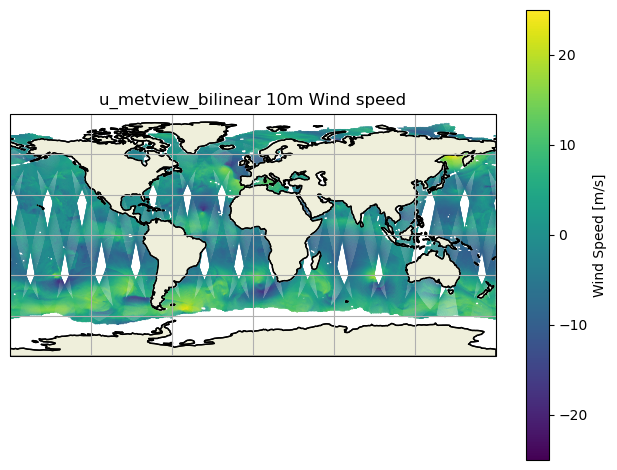

In [21]:
# Plot the resampled (Nearest neighb.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds.where(work_SAT_ds.sft==0), area_def_world, chan=-1, 
              var = 'u_metview_bilinear', begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'u_metview_bilinear', area_def_world, vmin=-25, vmax=25, 
                                   proj="PlateCarree", var = "u_metview_bilinear")

**pyResample-NNGW**

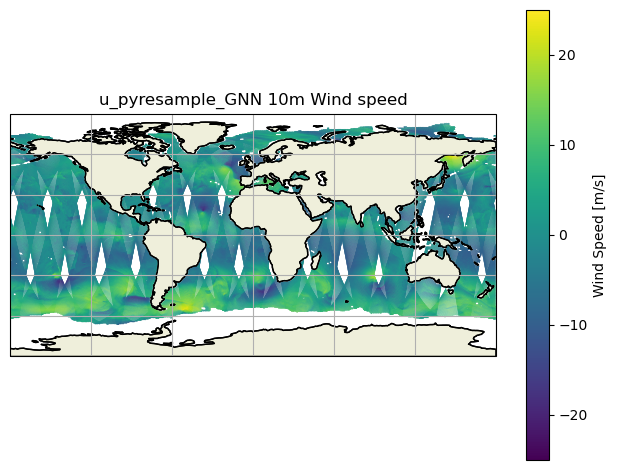

In [22]:
# Plot the resampled (Nearest neighb.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds.where(work_SAT_ds.sft==0), area_def_world, chan=-1, 
              var = 'u_pyresample_GNN', begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'u_pyresample_GNN', area_def_world, vmin=-25, vmax=25, 
                                   proj="PlateCarree", var = "u_pyresample_GNN")

# Comparison Nearest Neighbours Gaussian weights and bilinear interpolation

Here we compute the difference and look at different metrics.

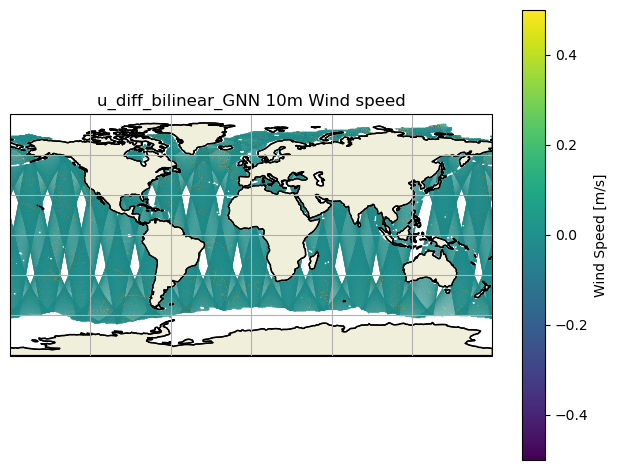

In [23]:
# Plot the resampled (Nearest neighb.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds.where(work_SAT_ds.sft==0), area_def_world, chan=-1, 
              var = 'u_diff_bilinear_GNN', begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'u_diff_bilinear_GNN', area_def_world, vmin=-0.5, vmax=0.5, 
                                   proj="PlateCarree", var = "u_diff_bilinear_GNN")

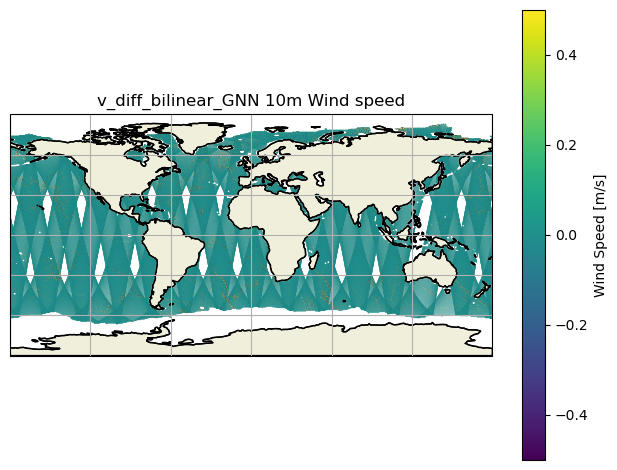

In [24]:
# Plot the resampled (Nearest neighb.) ECMWF data in the new 'grid' 
# (i.e. the satellite swath):

reduced_lon_scene, reduced_lat_scene, reduced_data_scene =\
support_routines.get_Sat_frame(work_SAT_ds.where(work_SAT_ds.sft==0), area_def_world, chan=-1, 
              var = 'v_diff_bilinear_GNN', begin_t=None, end_t=None)

support_routines.basicMapPlotScat1(reduced_lon_scene, reduced_lat_scene, reduced_data_scene,
                 'v_diff_bilinear_GNN', area_def_world, vmin=-0.5, vmax=0.5, 
                                   proj="PlateCarree", var = "v_diff_bilinear_GNN")

Lets plot the histogram of the differences:

(array([8.000000e+00, 7.700000e+01, 3.260000e+02, 4.498000e+03,
        1.789914e+06, 1.619660e+05, 1.963000e+03, 2.170000e+02,
        3.200000e+01, 1.100000e+01]),
 array([-2.65470047, -2.1074143 , -1.56012814, -1.01284198, -0.46555581,
         0.08173035,  0.62901652,  1.17630268,  1.72358884,  2.27087501,
         2.81816117]),
 <BarContainer object of 10 artists>)

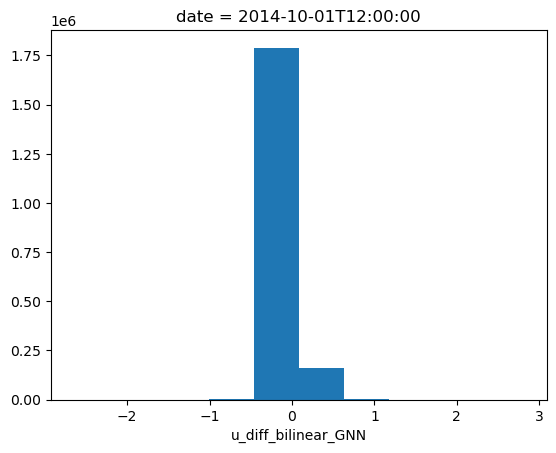

In [25]:
xr.plot.hist(work_SAT_ds['u_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))

(array([2.000000e+00, 1.300000e+01, 3.000000e+01, 2.050000e+02,
        3.249000e+03, 1.944911e+06, 1.016900e+04, 3.750000e+02,
        4.300000e+01, 1.500000e+01]),
 array([-5.5116007 , -4.53112321, -3.55064571, -2.57016822, -1.58969073,
        -0.60921324,  0.37126426,  1.35174175,  2.33221924,  3.31269674,
         4.29317423]),
 <BarContainer object of 10 artists>)

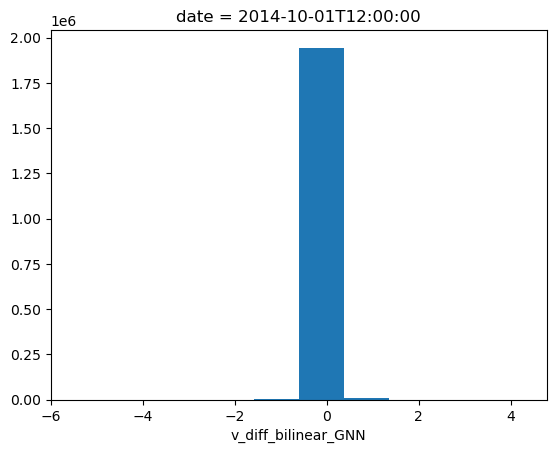

In [26]:
xr.plot.hist(work_SAT_ds['v_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))

Finally lets define a metric of how similar is the **pyResample-NNGW** to the **MetView-Bilinear**:

The percentage of samples whose differences are below a threshold in *m/s*. 

This is an arbitrary metric and it tries to resemble the way of presenting differences between two different libraries used at ECMWF: [MIR vs EMOSLIB](https://confluence.ecmwf.int/display/UDOC/Differences+for+10m+winds).

Here we focus on the ocean samples.

In [27]:
np.sum(np.abs(work_SAT_ds['u_diff_bilinear_GNN'].where(
    work_SAT_ds.sft==0))<0.2).values / np.sum(~np.isnan(
    work_SAT_ds['u_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))).values


0.9634402443680794

In [28]:
np.sum(np.abs(work_SAT_ds['v_diff_bilinear_GNN'].where(
    work_SAT_ds.sft==0))<0.2).values / np.sum(~np.isnan(
    work_SAT_ds['v_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))).values

0.9614244323158817

## Sigma and Neighbours:
When using the *pyResample*'s NN Gaussian weights we have two parameters that influence the resulting resampling: the width of the Gaussian (*sigma*) and the number of Neighbours used for the sample. 
For simplicity I checked different values for the **number of Neighbours** ranging from 4 to 20 and no noticeable differences were noted in the statistics obtained. This is a more relevant parameter for resampling among different satellite swaths (in both source and target swaths). Therefore at this stage this is a parameter that controls the speed of the resampler. For now 10 neighbours provide good speed and the reader is encouraged to play with this number.

Here we want to check how sensitive is the resulting resampling scheme; for this we use the Bilinear interpolation from *MetView* as a fixed "truth" and we use initially the following metric: the percentage of results with differences lower than *0.2 m/s*. 



In [40]:
# Very lame way of printing statistics:
def computePrintStats(ds,var1,var2,sigma):
    
    print('Some statistics for sigma: '+str(sigma))
    print('    Min. diff. u, v: '+str(
        ds[var1].where(ds.sft==0).min().values)+\
          ' , '+str(ds[var2].where(ds.sft==0
                                 ).min().values))
    print('    Max. diff. u, v: '+str(
        ds[var1].where(ds.sft==0).max().values)+\
          ' , '+str(ds[var2].where(ds.sft==0
                                  ).max().values))
    print('    Mean diff. u, v: '+str(
        abs(ds[var1].where(ds.sft==0)).mean().values)+\
          ' , '+str(abs(ds[var2].where(ds.sft==0
                                      )).mean().values))
    print('    Std. diff. u, v: '+str(
        abs(ds[var1].where(ds.sft==0)).std().values)+\
          ' , '+str(abs(ds[var2].where(ds.sft==0)).std().values))
    

In [43]:
wind_threshold = 0.1 # [m/s]
sigmas = [10000,15000,20000,25000,30000,35000,40000,45000,50000] # [m]
neighbours = 10

# Accumulate fraction of differences < wind_threshold
percent_u = []
percent_v = []

startTime = time.time()

for sigma in sigmas:
    work_SAT_ds['u_pyresample_GNN'] = xr.DataArray(
        data   = resample_gauss(ECMWF_grid_def_RG,
                           xarray_ds.u10n[0,0,:].values, 
                           SAT_swath_def,
                           radius_of_influence=30000,
                           neighbours = neighbours,
                           sigmas=sigma,
                           #*np.ones(#len(work_ECMWF_ds_RG.time2.values)),
                           fill_value=None),  # enter data here
        dims   = ['time','scene_across_track'],
        coords = {'time': work_SAT_ds.time, 
              'scene_across_track': work_SAT_ds.scene_across_track,},
        attrs  = {#'_FillValue': -999.9,
            'description': 'u10n from ECMWFs forecast resampled with\
            PyResample (Nearest Neighbour Gaussian weights) to satellite swath',
            'units'     : 'm/s'
        }
    ) 

    work_SAT_ds['v_pyresample_GNN'] = xr.DataArray(
        data   = resample_gauss(ECMWF_grid_def_RG,
                           xarray_ds.v10n[0,0,:].values, 
                           SAT_swath_def,
                           radius_of_influence=30000,
                           neighbours = neighbours,
                           sigmas=sigma,
                           #*np.ones(#len(work_ECMWF_ds_RG.time2.values)),
                           fill_value=None),  # enter data here
        dims   = ['time','scene_across_track'],
        coords = {'time': work_SAT_ds.time, 
              'scene_across_track': work_SAT_ds.scene_across_track,},
        attrs  = {#'_FillValue': -999.9,
            'description': 'v10n from ECMWFs forecast resampled with\
            PyResample (Nearest Neighbour Gaussian weights) to satellite swath',
            'units'     : 'm/s'
        }
    )      
    
    work_SAT_ds['u_diff_bilinear_GNN'] = work_SAT_ds['u_metview_bilinear']-\
        work_SAT_ds['u_pyresample_GNN']
    
    work_SAT_ds['v_diff_bilinear_GNN'] = work_SAT_ds['v_metview_bilinear']-\
        work_SAT_ds['v_pyresample_GNN']
    
    percent_u.append(np.sum(np.abs(work_SAT_ds['u_diff_bilinear_GNN'].where(
        work_SAT_ds.sft==0)) < wind_threshold).values / np.sum(~np.isnan(
        work_SAT_ds['u_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))).values)
    
    percent_v.append(np.sum(np.abs(work_SAT_ds['v_diff_bilinear_GNN'].where(
        work_SAT_ds.sft==0)) < wind_threshold).values / np.sum(~np.isnan(
        work_SAT_ds['v_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))).values)
    
    computePrintStats(work_SAT_ds,
                      var1 = 'u_diff_bilinear_GNN',
                      var2 = 'v_diff_bilinear_GNN',
                      sigma = sigma)
    
    
print("%.2f s , Time NN Gaussian weights" % (time.time()-startTime))     

Some statistics for sigma: 10000
    Min. diff. u, v: -4.890012173883268 , -8.38481045219412
    Max. diff. u, v: 5.089271653377196 , 7.284381820035809
    Mean diff. u, v: 0.12274649459661481 , 0.1254509203318612
    Std. diff. u, v: 0.16937243224979853 , 0.1893316199355438
Some statistics for sigma: 15000
    Min. diff. u, v: -2.549048285201692 , -4.5761529688215985
    Max. diff. u, v: 2.7073517981861093 , 3.9969578387424223
    Mean diff. u, v: 0.06429851789154545 , 0.06534786739567214
    Std. diff. u, v: 0.0879560145639173 , 0.09641329540051227
Some statistics for sigma: 20000
    Min. diff. u, v: -1.6589069970231387 , -1.7562749115509337
    Max. diff. u, v: 1.3960337328009187 , 1.8226955596478795
    Mean diff. u, v: 0.021911807570269736 , 0.02220412425702909
    Std. diff. u, v: 0.034933993853218916 , 0.03735196639011665
Some statistics for sigma: 25000
    Min. diff. u, v: -1.7583096798075846 , -3.974004822088368
    Max. diff. u, v: 1.9866197045793381 , 3.009730455913643
   

Text(22500.0, 0.9706397918950982, '0.9706397918950982')

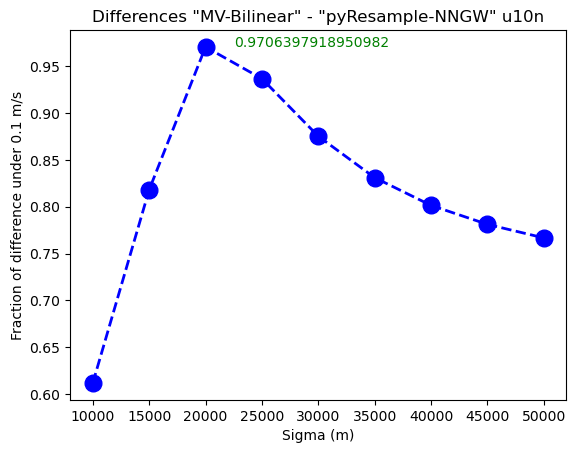

In [36]:
plt.plot(sigmas, percent_u, 'bo--', linewidth=2, markersize=12)
plt.title('Differences "MV-Bilinear" - "pyResample-NNGW" u10n')
plt.xlabel('Sigma (m)')
plt.ylabel('Fraction of difference under 0.1 m/s')
plt.text(sigmas[np.argmax(np.array(percent_u)
                         )]+0.05*np.max(np.array(sigmas)), np.max(np.array(percent_u)), 
         str(np.max(np.array(percent_u))), color='green')

Text(22500.0, 0.9699190204041629, '0.9699190204041629')

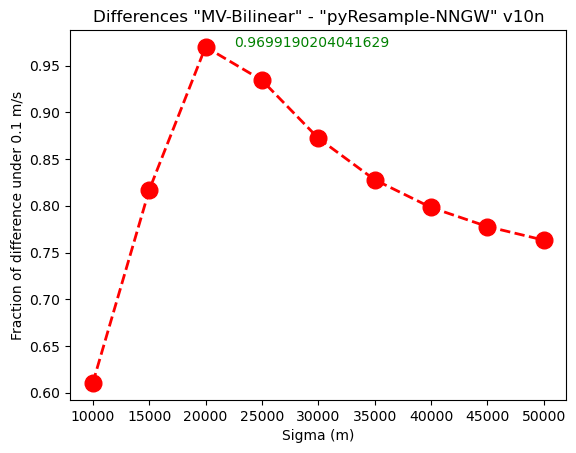

In [37]:
plt.plot(sigmas, percent_v, 'ro--', linewidth=2, markersize=12)
plt.title('Differences "MV-Bilinear" - "pyResample-NNGW" v10n')
plt.xlabel('Sigma (m)')
plt.ylabel('Fraction of difference under 0.1 m/s')
plt.text(sigmas[np.argmax(np.array(percent_v)
                         )]+0.05*np.max(np.array(sigmas)), np.max(np.array(percent_v)), 
         str(np.max(np.array(percent_v))), color='green')

One can of course spend more time checking the parameter at hand (sigmas); with this short experiment, we checked the resampling onto a satellite grid equivalent to 1 full day of observations over the ocean, almost 2 million points:

In [39]:
str(np.sum(~np.isnan(
        work_SAT_ds['v_diff_bilinear_GNN'].where(work_SAT_ds.sft==0))).values)

'1959012'

# A few notes from the software design point of view

MetView offers a powerful set of tools to perform regridding; moreover it is a tool developed by ECMWF, which gives confidence in the results. At the same time, its interface is oriented towards ECMWF's products, which can be cumbersome to use with external datasets or simply products that are not ECMWF's: satellite observations, other data providers.

On the other hand using *xarray* + *pyResample* gives not only flexibility for reading, exploring and processing datasets in geoscience, thanks to the reuse of the power of libraries like Numpy, scipy, and Dask on xarray's side, **plus** the heavy influence from satellite applications coming from [pyTroll](https://pytroll.github.io/).

These facts simply present a tradeoff that needs to consider future developments, applications and collaboration:
- **Future developments** in satellite products for example, will require resampling that can be used across different satellite platforms **and** at the same time for resampling model data (such as ECMWF). Using the same tooling for *both* applications is simply more consistent.
- **New applications** require flexibility and the capability to move back and forth between pure satellite processing and for example Machine Learning (ML) tools. A lot of tooling from the ML universe is available and directly usable within the flexible xarray-Numpy-Dask-Scipy-ScikitLearn universe.
- **Collaboration** requires reuse of open source tooling, but also the reuse of tools in a transparent way: interoperability between Numpy, xarray, Dask, Pandas, Matplotlib (for plotting) is an example among very different communities (not only geoscience, satellite observations, ML, Computer Vision, etc.). The ability to resample datasets from different potential partners is essential.